# TF-IDF Analysis of Spark PRs with spaCy and Scikit-Learn 

This notebook was used to calculate the TF-IDF of Spark commit messages and PRs with spaCy and Scikit-Learn. 

First, we extract the useful descriptions and comments from Spark issues. 

Second, we use spaCy to do tokenization, remove stop words and reduce inflected words to their root stem. 

Third, we use Scikit-Learn to calculate its TF-IDF.

## Installation

If you use Linux-like system, (including, to greater or lesser degrees, Ubuntu, MacOS, Cygwin, and Bash for Windows), you should be able to run these commands to install SpaCy, Scikit-Learn, Pandas, and the other required libraries. Ete3 is a library for tree visualization which is optional.

    sudo pip install spacy scikit-learn pandas ete3

Now download the SpaCy data with this command:

    python -m spacy.en.download all

## Extract the useful information from Spark issues

In [86]:
#coding=utf-8
import xml.dom.minidom
import re
import os

#Remove some XML headers
def remove(data):
    data = re.sub(r'</?p>', "", data)
    data = re.sub(r'</?tt>', "", data)
    data = re.sub(r'<br/>', "", data)
    data = re.sub(r'\<a.*?\>', "", data)
    data = re.sub(r'</a>', "", data)
    data = re.sub(r'\<div.*?\>', "", data)
    data = re.sub(r'\</div\>', "", data)
    data = re.sub(r'\<pre.*?\>', "", data)
    data = re.sub(r'\</pre\>', "", data)
    data = re.sub(r'\<span.*?\>', "", data)
    data = re.sub(r'\</span\>', "", data)
    data = re.sub(r'\<ul.*?\>', "", data)
    data = re.sub(r'</ul\>', "", data)
    data = re.sub(r'\<table.*?\>', "", data)
    data = re.sub(r'\</table\>', "", data)
    data = re.sub(r'\<td.*?\>', "", data)
    data = re.sub(r'\</td\>', "", data)
    data = re.sub(r'\<th.*?\>', "", data)
    data = re.sub(r'\</th\>', "", data)
    data = re.sub(r'\</?del\>', "", data)
    data = re.sub(r'\</?em\>', "", data)
    data = re.sub(r'\</?h3\>', "", data)
    data = re.sub(r'\</?li\>', "", data)
    data = re.sub(r'</?ol>', "", data)
    data = re.sub(r'</?tr>', "", data)
    data = re.sub(r'</?tbody>', "", data)
    data = re.sub(r'\<img.*?\>', "", data)
    data = re.sub(r'\n', " ", data)
    data = re.sub(r'\&gt\;', ">", data)
    data = re.sub(r'\&lt\;', "<", data)
    data = re.sub(r'\&\#91\;', "[", data)
    data = re.sub(r'\&\#93\;', "]", data)
    data = re.sub(r'\&\#8211\;', "-", data)
    data = re.sub(r'\&amp\;', "&", data)
    data = re.sub(r'\<200c\>', "", data)
    data = re.sub(r'\<200b\>', "", data)
    return data

#Get title, description and comments
def readInfoFromXML(root, toFile):
    fopen = open(toFile, 'w')
    title = root.getElementsByTagName('title')
    for i, ti in enumerate(title):
        if i != 0:
            data = ti.firstChild.data
            data = re.sub(r'\[.*?\]\s', "", data)
            data = remove(data)
            fopen.write('%s\n' % (data))
    description = root.getElementsByTagName('description')
    for i, des in enumerate(description):
        if i != 0 and des.firstChild != None:
            data = remove(des.firstChild.data)
            fopen.write('%s\n' % (data.encode('utf-8')))
    comments = root.getElementsByTagName('comment')
    for i, com in enumerate(comments):
        data = remove(com.firstChild.data)
        fopen.write('%s\n' % (data.encode('utf-8')))
    fopen.close()

#Write the extracted information to new dir and files
def getInfoFromXML(fromDir, path):
    toDir = "./data/desAndCom/"
    fromFile = os.path.join('%s%s' % (fromDir, path))
    toFile = os.path.join('%s%s' % (toDir, path))
    #print fromFile, toFile, path
    dom = xml.dom.minidom.parse(fromFile)
    root = dom.documentElement
    readInfoFromXML(root, toFile)

In [87]:
#The file operations

#Print all files of this dir 'filepath'
def eachFile(filepath):
    pathDir =  os.listdir(filepath)
    for allDir in pathDir:
        child = os.path.join('%s%s' % (filepath, allDir))
        print child.decode('gbk')

#Print the content of this file 'filename'
def readFile(filename):
    fopen = open(filename, 'r') 
    for eachLine in fopen:
        print "the content of this line", line
    fopen.close()

#Write multiple lines to a specific file
def writeFile(filename):
    fopen = open(filename, 'w')
    while True:
        aLine = raw_input()
        if aLine != ".":
            fopen.write('%s%s' % (aLine, os.linesep))
        else:
            print "the file is saved"
            break
    fopen.close()

In [88]:
#Get all description and comments for spaCy
def getUsefulInfo(filepath):
    pathDir =  os.listdir(filepath)
    subName = "SPARK"                           #now only extract from spark JRs
    invalidName = "invalid"
    for allDir in pathDir:
        if subName in allDir:
            if invalidName in allDir:
                continue
            getInfoFromXML(filepath, allDir)
            #print allDir

filePath = "./data/spark-issues/"
#eachFile(filePath)
getUsefulInfo(filePath)                         #write all useful information to ./data/desAndCom

## Use spaCy to do tokenization, stemming and remove stop words 

In [89]:
import spacy

In [90]:
#This command will load the model of spaCy, which might take a little while. 
nlp = spacy.load('en-core-web-md')

In [91]:
#Get all extracted files
fileList =  os.listdir("./data/desAndCom/")
fileDir = "./data/desAndCom/"
files = []
for tempFile in fileList:
    if "ipynb" in tempFile:
        continue
    files.append(os.path.join('%s%s' % (fileDir, tempFile)))
print len(files)  

93


In [92]:
#Use spaCy to analysis these files
text_num = len(files)
text_array = [[]] * text_num
for i, tempFile in enumerate(files):
    raw_data = open(files[i]).read()
    text_array[i] = nlp(raw_data.decode('utf-8'))
print files[0]
print text_array[0]

./data/desAndCom/00e7b09a0b-SPARK-7553.xml
Add methods to maintain a singleton StreamingContext 
In a REPL/notebook environment, its very easy to lose a reference to a StreamingContext by overriding the variable name. So if you happen to execute the following commands  {{ val ssc = new StreamingContext(...)  // cmd 1 ssc.start()                     // cmd 2 ... val ssc = new StreamingContext(...)   // accidentally run cmd 1 again }}  The value of ssc will be overwritten. Now you can neither start the new context (as only one context can be started), nor stop the previous context (as the reference is lost).  Hence its best to maintain a singleton reference to the active context, so that we never loose reference for the active context.   Since this problem occurs useful in REPL environments, its best to add this as an Experimental support in the Scala API only so that it can be used in Scala REPLs and notebooks. 
User 'tdas' has created a pull request for this issue: https://github.com/a

In [93]:
#Just for checking
#for token in text_array[0]:
#    print (token, token.lemma_, token.lemma, token.pos_, token.pos, token.is_stop)

In [94]:
#Remove punctuation, brackets, stop words ,etc
#Note SYMBOL, such as '='， capitals, steming will be dealed next
for i, token in enumerate(text_array[0]):
    if token.is_punct or token.is_space or token.is_stop:
        continue
    print (token, token.lemma_, token.lemma, token.pos_, token.pos, token.is_stop)

(Add, u'add', 1646, u'VERB', 98, False)
(methods, u'method', 2559, u'NOUN', 90, False)
(maintain, u'maintain', 3332, u'VERB', 98, False)
(singleton, u'singleton', 263228, u'NOUN', 90, False)
(StreamingContext, u'streamingcontext', 776981, u'PROPN', 94, False)
(REPL/notebook, u'repl/notebook', 776983, u'NOUN', 90, False)
(environment, u'environment', 2309, u'NOUN', 90, False)
(easy, u'easy', 1253, u'ADJ', 82, False)
(lose, u'lose', 1564, u'VERB', 98, False)
(reference, u'reference', 2358, u'NOUN', 90, False)
(StreamingContext, u'streamingcontext', 776981, u'PROPN', 94, False)
(overriding, u'override', 509640, u'VERB', 98, False)
(variable, u'variable', 7031, u'ADJ', 82, False)
(happen, u'happen', 1132, u'VERB', 98, False)
(execute, u'execute', 8879, u'VERB', 98, False)
(following, u'follow', 1933, u'VERB', 98, False)
(commands, u'command', 4341, u'NOUN', 90, False)
(val, u'val', 4995, u'NOUN', 90, False)
(ssc, u'ssc', 378797, u'NOUN', 90, False)
(=, u'=', 1136, u'SYM', 97, False)
(new, 

In [95]:
#Write the intermediate results to files
fileList = os.listdir("./data/desAndCom/")
fileDir = "./data/clearFiles/"
files = []
for tempFile in fileList:
    if "ipynb" in tempFile:
        continue
    files.append(os.path.join('%s%s' % (fileDir, tempFile)))

for j in range(text_num):
    fopen = open(files[j], 'w')
    for i, token in enumerate(text_array[j]):
        if token.is_punct or token.is_space or token.is_stop or token.pos_ == 'SYM':   #include symbor, such as "="
            continue
        fopen.write(token.lemma_.encode('utf8') + " ")   #reduce all words to its root stem
        #print token.lemma_
    fopen.close()

## Use Scikit-Learn to calculate the TF-IDF

In [96]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

from collections import Counter
from glob import glob
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline


In [97]:
# Reload the clear files and use the spaCy models to analyze them
# We can analyze them for the occurence portation of different kinds of words
text_num = len(files)
text_array = [] * text_num
for i, tempFile in enumerate(files):
    raw_data = open(files[i]).read()
    text_array.append(nlp(raw_data.decode('utf-8')))
print files[0]
print text_array[0]

./data/clearFiles/00e7b09a0b-SPARK-7553.xml
add method maintain singleton streamingcontext repl/notebook environment easy lose reference streamingcontext override variable happen execute follow command val ssc new streamingcontext cmd 1 ssc.start cmd 2 val ssc new streamingcontext accidentally run cmd 1 value ssc overwritten start new context context start stop previous context reference lose good maintain singleton reference active context loose reference active context problem occur useful repl environment good add experimental support scala api scala repls notebook user tdas create pull request issue https://github.com/apache/spark/pull/6070 


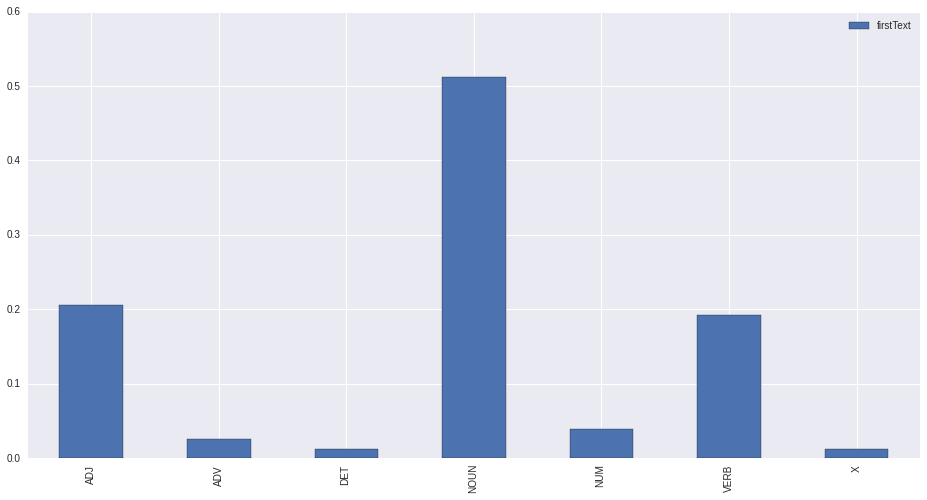

In [98]:
# Use the percentage of different POS in a article to draw a picture
textPOS = [] * text_num
for i, tempFile in enumerate(files):
    textPOS.append(pd.Series(text_array[i].count_by(spacy.attrs.POS))/len(text_array[i]))     # the sequence of POS percentages

tagDict = {w.pos: w.pos_ for w in text_array[0]} 
rcParams['figure.figsize'] = 16, 8
df = pd.DataFrame([textPOS[0]], index=['firstText'])  # the figure configuration
df.columns = [tagDict[column] for column in df.columns]                 # the columns configuration
df.T.plot(kind='bar')

In [99]:
# Document Vectorization
# First, we'll vectorize the corpus using scikit-learn's TfidfVectorizer class.
tfidf = TfidfVectorizer(input='filename', decode_error='ignore', use_idf=True)

In [100]:
testFilenames = sorted(glob('./data/clearFiles/*'))
#print testFilenames

# Make labels by removing the directory name and .txt extension: 
labels = [filename.split('/')[3] for filename in testFilenames]
labels = [filename.split('.')[0] for filename in labels]
#print labels


# While we're at it, let's make a list of the lengths, so we can use them to plot dot sizes. 
lengths = [len(open(filename).read())/100 for filename in testFilenames]
#print lengths

# Add a manually compiled list of presidential party affiliations, 
# So that we can use this to color our dots. 
parties = 'rrrbbrrrbbbbbrrbbrrbrrrbbrrbr'

In [101]:
tfidfOut = tfidf.fit_transform(testFilenames)
tfidfOut

<93x3005 sparse matrix of type '<type 'numpy.float64'>'
	with 7072 stored elements in Compressed Sparse Row format>

In [102]:
#print the tfidf of all words in different documents
feature_names = tfidf.get_feature_names()
#print feature_names

#print the TFIDF of two articles
print '\n------------------------ the TFIDF of two articles ---------------------------------'
temp = 0
feature_index = tfidfOut[temp,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidfOut[temp, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print w, s
print '-----------------------------------------------------------------------'
temp = 1
feature_index = tfidfOut[temp,:].nonzero()[1]
tfidf_scores = zip(feature_index, [tfidfOut[temp, x] for x in feature_index])
for w, s in [(feature_names[i], s) for (i, s) in tfidf_scores]:
    print w, s


------------------------ the TFIDF of two articles ---------------------------------
refector 0.136254707276
option 0.194619359285
correctly 0.105391503082
form 0.124864016898
case 0.275563509138
class 0.511065757267
csvparameter 0.136254707276
look 0.167340715107
like 0.0701977593907
normal 0.124864016898
refactor 0.221026888367
similar 0.101060963585
jsonoption 0.272509414551
work 0.0611301190444
actually 0.110513444184
think 0.14601878779
csvoption 0.272509414551
easy 0.101060963585
consume 0.124864016898
duplicate 0.105391503082
json 0.233564386918
maybe 0.110513444184
be 0.0566615306251
good 0.088363391101
change 0.0641978437371
match 0.110513444184
csv 0.136254707276
not 0.0601777261732
ne 0.0796502399897
sure 0.0836703575536
great 0.0973096796427
use 0.065299667275
format 0.101060963585
thank 0.0778371658262
ah 0.136254707276
get 0.0940008127043
user 0.0315891776847
hyukjinkwon 0.116782193459
create 0.0309202675331
pull 0.0592568247718
request 0.030591691868
issue 0.03059169186

In [103]:
#The matrix of TFIDF of all documents, 93 is the number of articles and 3005 is the number of words
tfidfOut.shape

(93, 3005)

In [104]:
lsa = TruncatedSVD(n_components=2)
lsaOut = lsa.fit_transform(tfidfOut.todense())

IndexError: string index out of range

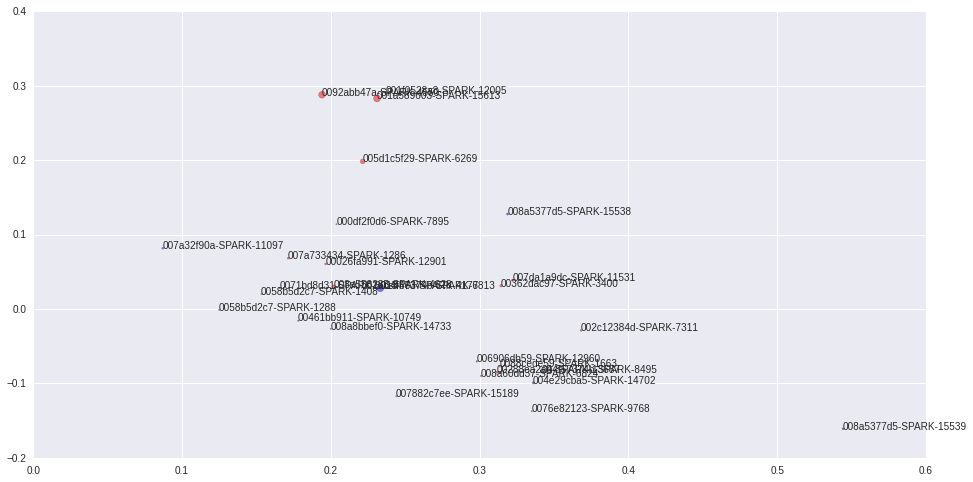

In [105]:
#The classification of all documents
xs, ys = lsaOut[:,0], lsaOut[:,1]
for i in range(len(xs)): 
    plt.scatter(xs[i], ys[i], c=parties[i], s=lengths[i], alpha=0.5)
    plt.annotate(labels[i], (xs[i], ys[i]))

In [106]:
# Term Frequency Distributions 
# We're simply going to count the occurrences of words and divide by the total number of words in the document.

doc_raw = [open(doc).read() for doc in testFilenames]
inaugural = [nlp(doc.decode("utf-8")) for doc in doc_raw]

# Create a Pandas Data Frame with each word counted in each document, divided by the length of the document. 
inauguralSeries = [pd.Series(Counter([word.string.strip().lower() for word in doc])) / len(doc) for doc in inaugural]
seriesDict = {label: series for label, series in zip(labels, inauguralSeries)}
inauguralDf = pd.DataFrame(seriesDict).T.fillna(0)

In [107]:
inauguralDf.head()

,$,','s,(,+,---------------------------+,-----------------------------+,--class,--master,--package,...,zoneddatetime.tolocaldate.toepochday.toint,zsxwing,|,|monotonically_increasing_id()|,|monotonicallyincreasingid()|,~10,~]$,—and,—rather,��??sr??java.util
00026fa991-SPARK-12901,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
000df2f0d6-SPARK-7895,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.037037,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
001a589603-SPARK-15613,0.0,0.0,0.004124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002062,0.000000,0.0,0.0,0.0,0.0,0.008247,0.0,0.0,0.0
001acc4463-SPARK-4177,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
001f0528a8-SPARK-12005,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


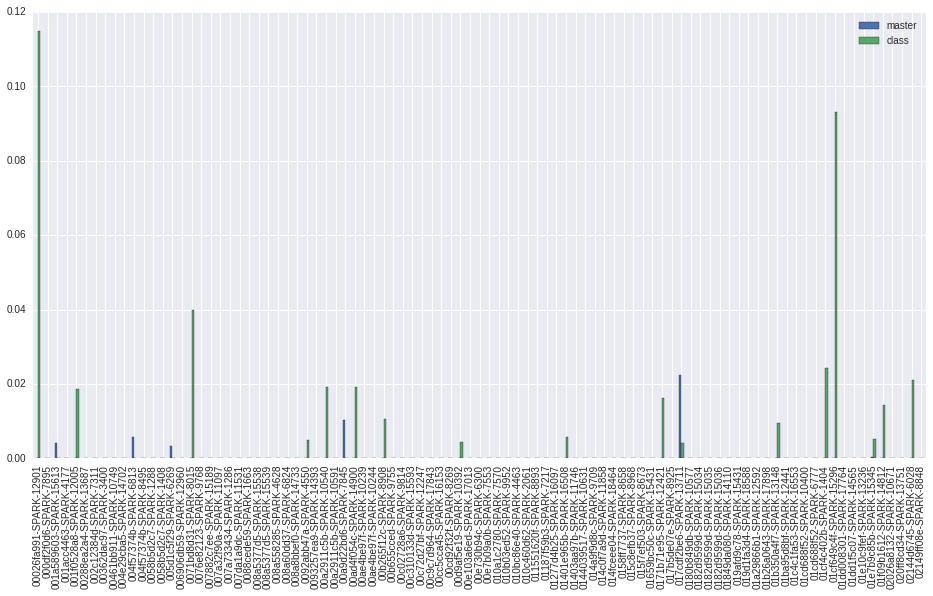

In [108]:
# We can easily slice this data frame with words we're interested in, and plot those words across the corpus. For example, 
# let's look at the proportions of the words "master" and "class":
inauguralDf[['master', 'class']].plot(kind='bar')

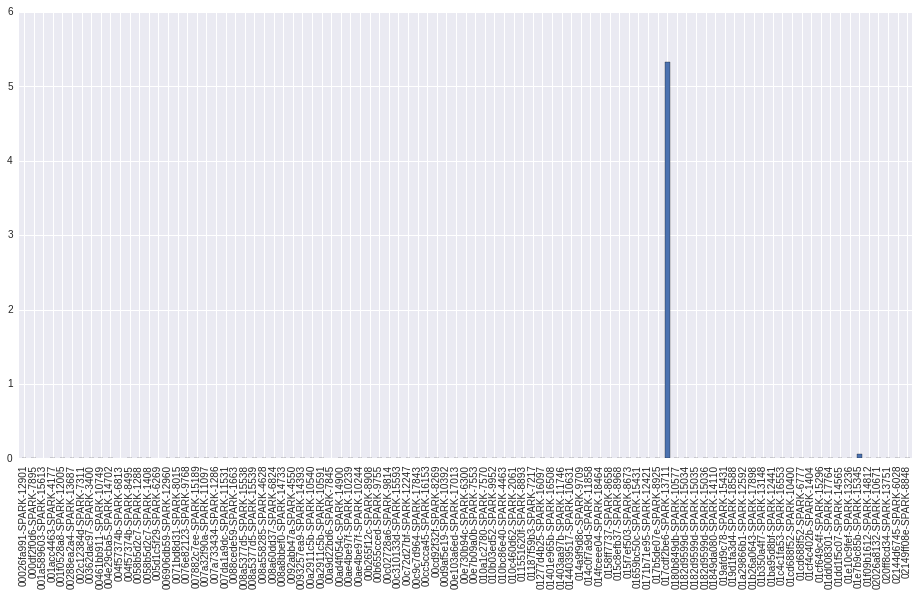

In [109]:
#We can even compute, say the ratio of uses of the word "master" to uses of the word "class."
americaWorldRatio = inauguralDf['master']/inauguralDf['class']
americaWorldRatio.plot(kind='bar')

In [110]:
#　Document Similarity Matrix
similarities = [ [doc.similarity(other) for other in inaugural] for doc in inaugural ]
similaritiesDf = pd.DataFrame(similarities, columns=labels, index=labels)

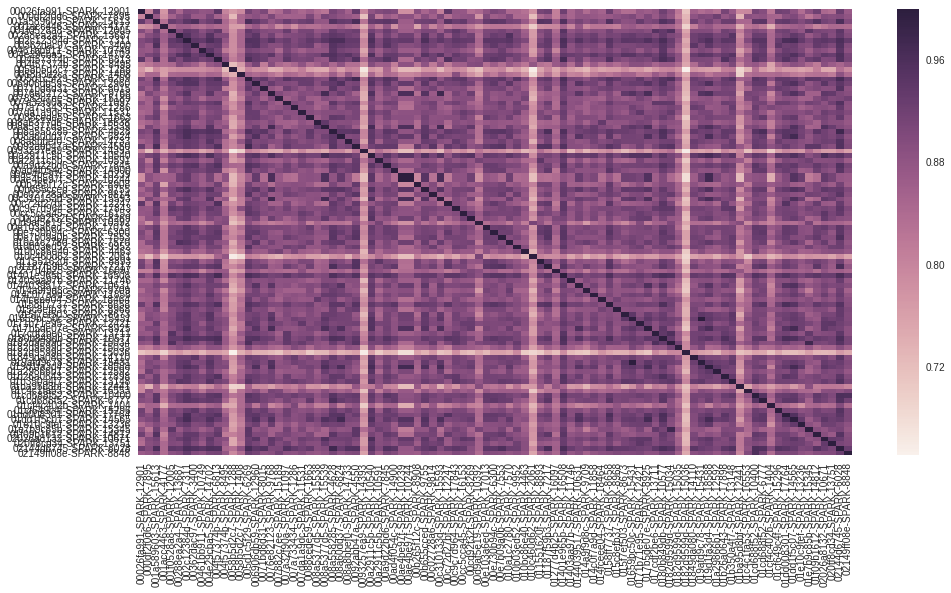

In [111]:
# Requires the Seaborn library. 
rcParams['figure.figsize'] = 16, 8
seaborn.heatmap(similaritiesDf)

In [112]:
# Get the top PROPN words
#firstAdjs = [w for w in first if w.pos_ == 'PROPN']
#Counter([w.string.strip() for w in firstAdjs]).most_common(10)